In [1]:
import numpy as np
from scipy.integrate import solve_ivp, OdeSolver
import matplotlib.pyplot as plt
from joblib import load

import os, sys
# local modules
directory_to_prepend = os.path.abspath("../../../src")
if directory_to_prepend not in sys.path:
    sys.path = [directory_to_prepend] + sys.path

from utils.utils import get_median_from_experiment, get_summary
from utils.swim import backward 
from hamiltonians.single_pendulum import SinglePendulum
from error_functions.index import l2_error, l2_error_relative, mean_squared_error, mean_absolute_error
from utils.grid import generate_grid
from utils.plot import plot_2d, plot_ground_truth_trajectory_2d, plot_predicted_trajectories_2d, plot_predicted_trajectory_errors, plot_predicted_trajectory_energy

# interesting result with 240 points only for single pendulum
EXPERIMENT_DIR = '../../../old_cluster/out/main/single_pendulum/random/[24]qtrain[10]ptrain_single_pendulum.pkl'

# single pendulum with 20 freq
#EXPERIMENT_DIR = '../../old_cluster/out/main/single_pendulum_20_freq_domain/random/smaller_domain/M_3000/[240]qtrain[100]ptrain_single_pendulum_20_freq.pkl'

# load experiment
experiment = load(EXPERIMENT_DIR)
print(f"-> LOADED EXPERIMENT: {EXPERIMENT_DIR}")
print(f"                      {experiment.keys()} ")
print(f"                      n_runs = {len(experiment['runs'])} ")
print(f"                      single run includes keys: {experiment['runs'][0].keys()}")
print(f"-> SUMMARY:\n{get_summary(experiment, ['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], ['test'], ['errors'], ['l2_error_relative'], ['median', 'mean'])}")
print(f"-> ")
print(f"-> ELM bias min: {np.min(experiment['runs'][0]['ELM'][0].biases)}, max: {np.max(experiment['runs'][0]['ELM'][0].biases)}")

domain_params = experiment['domain_params']
H = experiment['domain_params']['H']
dH = experiment['domain_params']['dH']

print(f"-> DOMAIN PARAMS: {domain_params}")
elm_params = experiment['elm_params']
uswim_params = experiment['uswim_params']
aswim_params = experiment['aswim_params']
swim_params = experiment['swim_params']

print(f"-> ELM PARAMS: {elm_params}")
print(f"-> USWIM PARAMS: {uswim_params}")
print(f"-> ASWIM PARAMS: {aswim_params}")
print(f"-> SWIM PARAMS: {swim_params}")

elm_median_error, _, _, ELM = get_median_from_experiment(EXPERIMENT_DIR, 'ELM', error_function='l2_error_relative') 
uswim_median_error, _, _, USWIM = get_median_from_experiment(EXPERIMENT_DIR, 'U-SWIM', error_function='l2_error_relative') 
aswim_median_error, _, _, ASWIM = get_median_from_experiment(EXPERIMENT_DIR, 'A-SWIM', error_function='l2_error_relative') 
swim_median_error, _, _, SWIM = get_median_from_experiment(EXPERIMENT_DIR, 'SWIM', error_function='l2_error_relative') 

print(f"-> MEDIAN ERRORS")
print(f"- ELM:    {elm_median_error}")
print(f"- U-SWIM: {uswim_median_error}")
print(f"- A-SWIM: {aswim_median_error}")
print(f"- SWIM:   {swim_median_error}")

-> LOADED EXPERIMENT: ../../../old_cluster/out/main/single_pendulum/random/[24]qtrain[10]ptrain_single_pendulum.pkl
                      dict_keys(['domain_params', 'elm_params', 'uswim_params', 'aswim_params', 'swim_params', 'runs']) 
                      n_runs = 100 
                      single run includes keys: dict_keys(['train_random_seed', 'test_random_seed', 'model_random_seed', 'train_errors', 'train_losses', 'test_errors', 'test_losses', 'train_times', 'ELM', 'U-SWIM', 'A-SWIM', 'SWIM'])
-> SUMMARY:
test errors median (l2_error_relative)
- ELM   	: 0.052340110279596196
- U-SWIM   	: 0.07984602921227156
- A-SWIM   	: 0.08563106167931672
- SWIM   	: 0.08475415531026917
test errors mean (l2_error_relative)
- ELM   	: 0.11347050275502162
- U-SWIM   	: 0.12075770825453803
- A-SWIM   	: 0.13130772388987197
- SWIM   	: 0.1315481309586765
-> 
-> ELM bias min: -6.274362052421215, max: 6.2779489439838825
-> DOMAIN PARAMS: {'system_name': 'single_pendulum', 'H': <bound method Single

# **Ground Truth**

q_plot_range shape (240,)
p_plot_range shape (100,)
q_plot_grid shape (100, 240)
p_plot_grid shape (100, 240)


<Figure size 640x480 with 0 Axes>

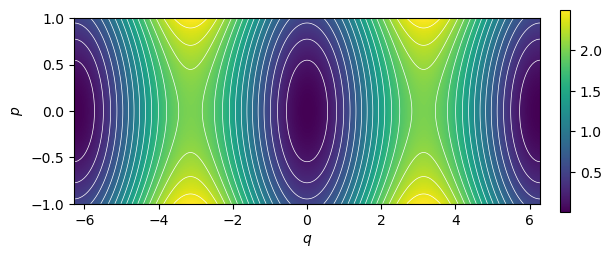


lim for q: [-6.28, 6.28]
lim for p: [-1.0, 1.0]


<Figure size 640x480 with 0 Axes>

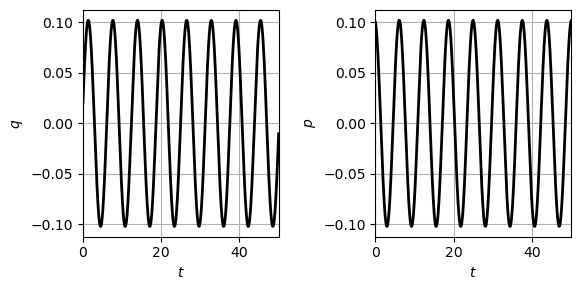

<Figure size 640x480 with 0 Axes>

In [2]:
#domain_params['q_test_lim'] = [[-6.28, 6.28]]
#domain_params['p_test_lim'] = [[-6, 6]]

# plot the ground truth phase space, linearly spaced in the test set range
[q_plot_range], [p_plot_range], [q_plot_grid], [p_plot_grid] = generate_grid(domain_params["q_test"], domain_params["p_test"], 
                                                                             domain_params["q_test_lim"], domain_params["p_test_lim"], dof=1, linspace=True)
print(f'q_plot_range shape {q_plot_range.shape}')
print(f'p_plot_range shape {p_plot_range.shape}')
print(f'q_plot_grid shape {q_plot_grid.shape}')
print(f'p_plot_grid shape {p_plot_grid.shape}')
x_plot  = np.column_stack([q_plot_grid.flatten(), p_plot_grid.flatten()]) # (N,2)
y_plot = H(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='single_pendulum_ground_truth_phase.pdf')

def dt_true(t, x): 
    """
    ground truth time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_true = dH(x).T.reshape(-1)
    #print("dH is:", str(dH))
    return [dH_true[1], -dH_true[0]] # [dH/dp, -dH/dq][q^dot, p^dot]

# RK45
t_span = [0, 50]
t_eval = np.linspace(t_span[0], t_span[1], 5000)
y0 = [0.02, 0.1]

pendulum_motion_true = solve_ivp(dt_true, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
# get integrated trajectories of shape (N,2)
traj_true = pendulum_motion_true.y.T

q_train_lim_start = experiment['domain_params']['q_train_lim'][0][0]
q_train_lim_end = experiment['domain_params']['q_train_lim'][0][1]
p_train_lim_start = experiment['domain_params']['p_train_lim'][0][0]
p_train_lim_end = experiment['domain_params']['p_train_lim'][0][1]
print(f"lim for q: [{q_train_lim_start}, {q_train_lim_end}]")
print(f"lim for p: [{p_train_lim_start}, {p_train_lim_end}]")
if np.any(traj_true[:,0] < q_train_lim_start):
    print(f"WARNING: found q={np.min(traj_true[:,0])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,0] > q_train_lim_end):
    print(f"WARNING: found q={np.max(traj_true[:,0])}, which is out of bounds for this experiment")
    
if np.any(traj_true[:,1] < p_train_lim_start):
    print(f"WARNING: found p={np.min(traj_true[:,1])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,1] > p_train_lim_end):
    print(f"WARNING: found p={np.max(traj_true[:,1])}, which is out of bounds for this experiment")

plot_ground_truth_trajectory_2d(t_span, t_eval, traj_true, verbose=True, save='single_pendulum_ground_truth_integration.pdf', linewidth=2)

# **Predictions**

<Figure size 640x480 with 0 Axes>

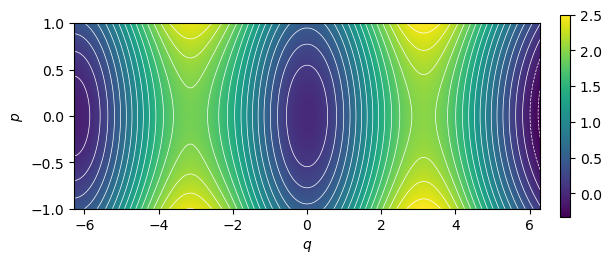

<Figure size 640x480 with 0 Axes>

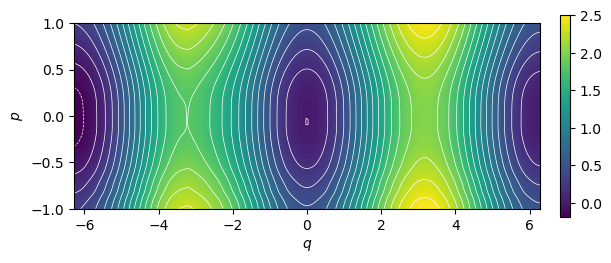

<Figure size 640x480 with 0 Axes>

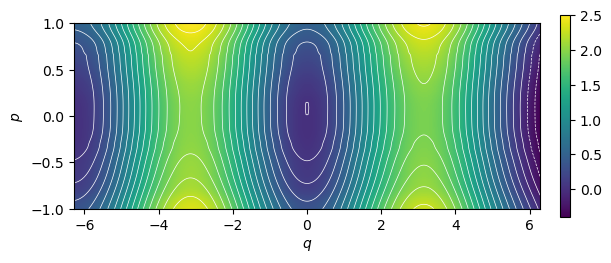

<Figure size 640x480 with 0 Axes>

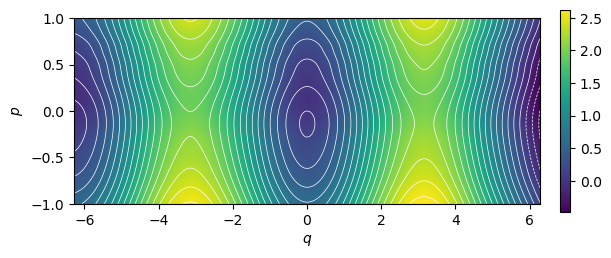


-> integrating ELM
-> integrating USWIM
-> integrating ASWIM
-> integrating SWIM


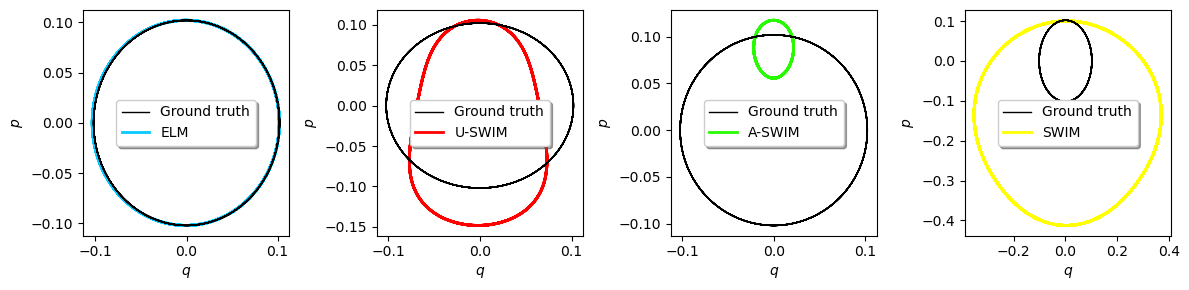

<Figure size 640x480 with 0 Axes>

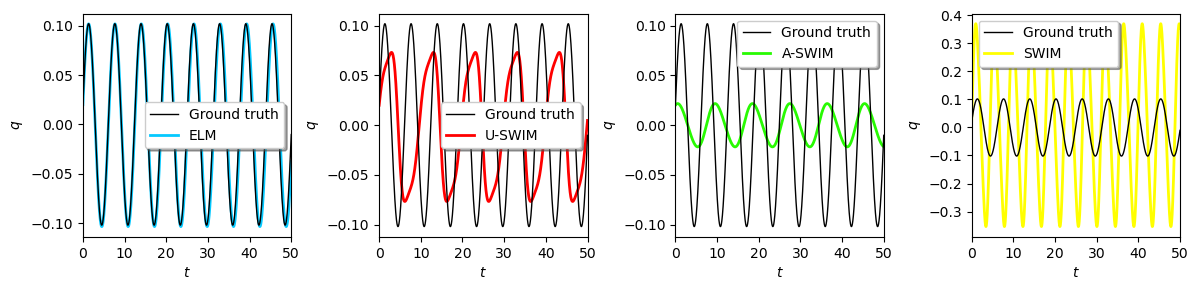

<Figure size 640x480 with 0 Axes>

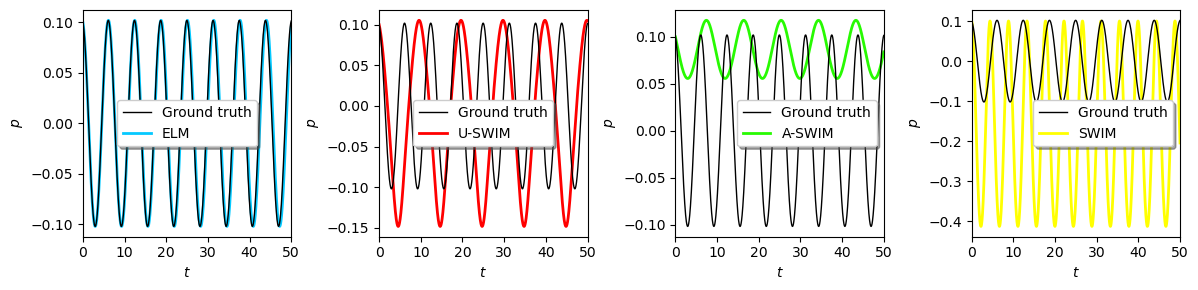

<Figure size 640x480 with 0 Axes>

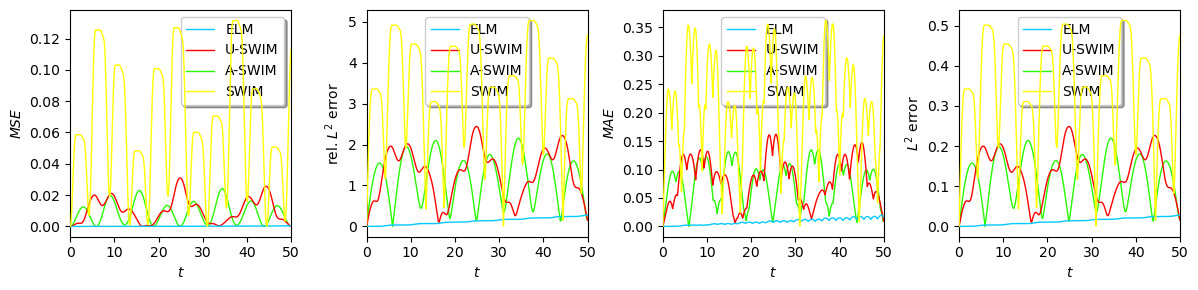

<Figure size 640x480 with 0 Axes>

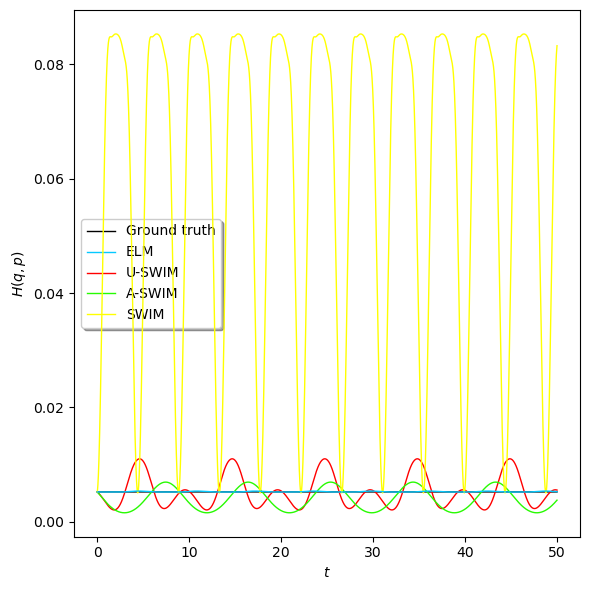

<Figure size 640x480 with 0 Axes>

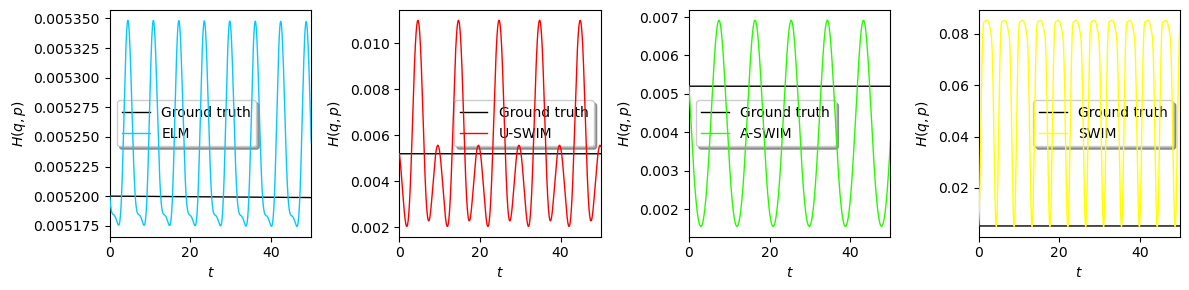

In [3]:
# phase
y_plot = ELM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='single_pendulum_elm_phase.pdf')
y_plot = USWIM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='single_pendulum_uswim_phase.pdf')
y_plot = ASWIM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='single_pendulum_aswim_phase.pdf')
y_plot = SWIM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='single_pendulum_swim_phase.pdf')

def dt_pred_elm(t, x):
    """
    ELM
    predicted time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ELM, elm_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_uswim(t, x):
    """
    U-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(USWIM, uswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_aswim(t, x):
    """
    A-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ASWIM, aswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_swim(t,x):
    """
    SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(SWIM, aswim_params['activation'], x).T.reshape(-1)
    return [dH_hat[1], -dH_hat[0]]

print(f"-> integrating ELM")
pendulum_motion_pred_elm = solve_ivp(dt_pred_elm, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating USWIM")
pendulum_motion_pred_uswim = solve_ivp(dt_pred_uswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating ASWIM")
pendulum_motion_pred_aswim = solve_ivp(dt_pred_aswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating SWIM")
pendulum_motion_pred_swim = solve_ivp(dt_pred_swim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)

# get integrated trajectories of shape (N,2)
traj_true = pendulum_motion_true.y.T
traj_pred_elm = pendulum_motion_pred_elm.y.T
traj_pred_uswim = pendulum_motion_pred_uswim.y.T
traj_pred_aswim = pendulum_motion_pred_aswim.y.T
traj_pred_swim = pendulum_motion_pred_swim.y.T

plot_predicted_trajectories_2d(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                               zorders=[2,1,1,1,1], linewidths=[1,2,2,2,2], verbose=True, 
                               save=['single_pendulum_predicted_integration_q_against_p.pdf', 'single_pendulum_predicted_integration_t_against_q.pdf', 'single_pendulum_predicted_integration_t_against_p.pdf'])



plot_predicted_trajectory_errors(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                                zorders=[5,4,3,8], linewidths=[1,1,1,1], verbose=True, save='single_pendulum_predicted_integration_errors.pdf')

# true energies at the predicted trajectories
energy_true = H(traj_true)
energy_elm = H(traj_pred_elm)
energy_uswim = H(traj_pred_uswim)
energy_aswim = H(traj_pred_aswim)
energy_swim = H(traj_pred_swim)

plot_predicted_trajectory_energy(t_span, t_eval, energy_true, energy_elm, energy_uswim, energy_aswim, energy_swim, 
                                 zorders=[2,14,7,8,9], linewidths=[1,1,1,1,1], verbose=True, save='single_pendulum_integration_energies.pdf')